# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [21]:
# TODO: Make all necessary imports.
# Imports here
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [22]:
# TODO: Load the dataset with TensorFlow Datasets.
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define directories
data_directory = '/kaggle/input/flowerclassificationdataset/FlowerClassificationDataset/FlowerClassificationDataset'
train_directory = f"{data_directory}/train"
validation_directory = f"{data_directory}/valid"
test_directory = f"{data_directory}/test"

# Parameters
BATCH_SIZE = 128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Load datasets
train_dataset = image_dataset_from_directory(
    train_directory,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    validation_directory,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_directory,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# TODO: Create a training set, a validation set and a test set.
# Get class names and number of classes
class_names = train_dataset.class_names
number_of_classes = len(class_names)
print(f"Number of classes: {number_of_classes}")

# Get the number of examples in each dataset
num_train_examples = tf.data.experimental.cardinality(train_dataset).numpy()
num_validation_examples = tf.data.experimental.cardinality(validation_dataset).numpy()
num_test_examples = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_validation_examples}")
print(f"Number of test examples: {num_test_examples}")

# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Mean and standard deviation for normalization
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

# Normalize images
def normalize_image(image, label):
    image = normalization_layer(image)
    image = (image - mean) / std
    return image, label

# Apply normalization to datasets
train_dataset = train_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch datasets for performance improvement
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.
Found 819 files belonging to 102 classes.
Number of classes: 102
Number of training examples: 52
Number of validation examples: 7
Number of test examples: 7


## Explore the Dataset

In [23]:
# TODO: Get the number of classes in the dataset from the dataset info.
# Function to get the class name from the label
def get_label_name(label):
    return class_names[label]


In [24]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        image = image_batch[i].numpy()
        label = label_batch[i].numpy()
        label_name = get_label_name(label)
        
        print(f"Shape of image {i+1}: {image.shape}")
        print(f"Label of image {i+1}: {label} ({label_name})")

Shape of image 1: (224, 224, 3)
Label of image 1: 19 (24)
Shape of image 2: (224, 224, 3)
Label of image 2: 14 (2)
Shape of image 3: (224, 224, 3)
Label of image 3: 93 (91)


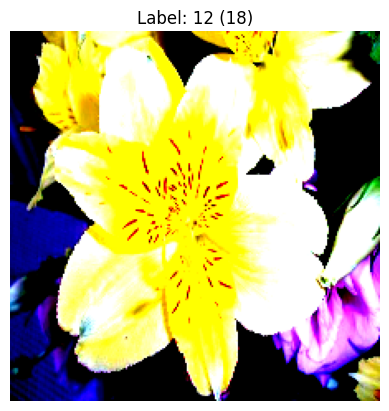

In [25]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
import matplotlib.pyplot as plt

# Plot 1 image from the training set with the title as the corresponding label
for image_batch, label_batch in train_dataset.take(1):
    image = image_batch[0].numpy()
    label = label_batch[0].numpy()
    label_name = get_label_name(label)

    plt.imshow(image)
    plt.title(f"Label: {label} ({label_name})")
    plt.axis('off')
    plt.show()
    break

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [26]:
with open('/kaggle/input/flowerclassificationdataset/label_map.json', 'r') as f:
    class_names = json.load(f)

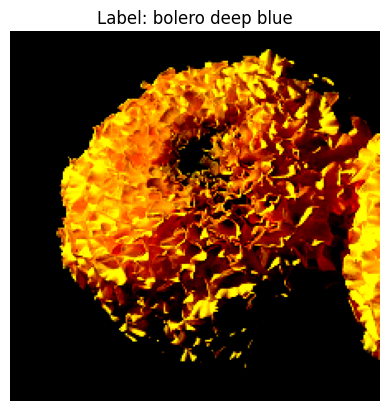

In [27]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
import matplotlib.pyplot as plt

# Function to get the class name from the label
def get_label_name(label):
    return class_names[str(label)]

# Plot 1 image from the training set with the title as the corresponding class name
for image_batch, label_batch in train_dataset.take(1):
    image = image_batch[0].numpy()
    label = label_batch[0].numpy()
    label_name = get_label_name(label)

    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.axis('off')
    plt.show()
    break

## Create Pipeline

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [28]:
# TODO: Build and train your network.
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Layer

@tf.keras.utils.register_keras_serializable()
class HubLayer(Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super(HubLayer, self).__init__(**kwargs)
        self.hub_url = hub_url
        self.trainable = trainable
        self.feature_extractor_layer = hub.KerasLayer(hub_url, trainable=trainable)
    
    def call(self, inputs):
        return self.feature_extractor_layer(inputs)
    
    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({
            "hub_url": self.hub_url,
            "trainable": self.trainable,
        })
        return config
    import tensorflow as tf
import matplotlib.pyplot as plt

num_classes = 102

# Loading MobileNet from TensorFlow Hub
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Creating the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = HubLayer(hub_url=mobilenet_url, trainable=False)(inputs)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)

Epoch 1/20
 3/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0252 - loss: 5.2438

W0000 00:00:1722540545.314459     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.0436 - loss: 4.6318 - val_accuracy: 0.2567 - val_loss: 3.5035
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2021 - loss: 3.5456 - val_accuracy: 0.4719 - val_loss: 2.3213
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3448 - loss: 2.6573 - val_accuracy: 0.6039 - val_loss: 1.7443
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4566 - loss: 2.1253 - val_accuracy: 0.6614 - val_loss: 1.3884
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5230 - loss: 1.7722 - val_accuracy: 0.7054 - val_loss: 1.2379
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5707 - loss: 1.6107 - val_accuracy: 0.7274 - val_loss: 1.0878
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6149 - loss: 1.4002 - val_accuracy: 0.7567 - val_loss: 0.9831
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6447 - loss: 1.2721 - val_accuracy: 0.7702 - val_loss: 

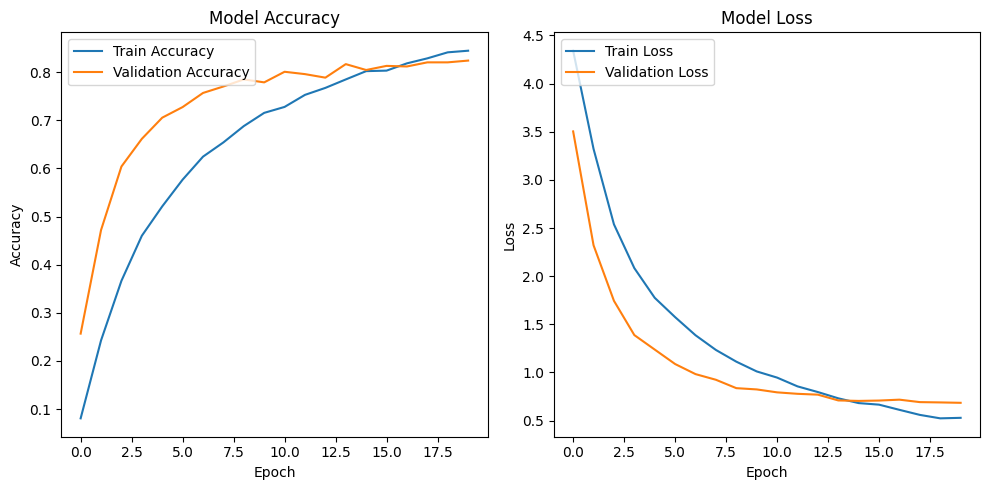

In [29]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [30]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_dataset)

print(f'Loss on Test Set: {loss}')
print(f'Accuracy on Test Set: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7871 - loss: 0.7853  
Loss on Test Set: 0.7825326323509216
Accuracy on Test Set: 0.7826617956161499


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [31]:
# TODO: Save your trained model as a Keras model.
model.save('/kaggle/working/basil.h5')

## Load the Keras Model

Load the Keras model you saved above.

In [32]:
# TODO: Load the Keras model
import tensorflow as tf

# Load the previously saved Keras model.
loaded_model = tf.keras.models.load_model('/kaggle/working/basil.h5')

# Print the model architecture summary.
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_2 (HubLayer)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,416 (3.10 MB)

 Trainable params: 813,414 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [33]:
# TODO: Create the process_image function
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

def process_image(image_path):
    # Open the image file.
    image = Image.open(image_path)
    
    # Convert the image to a NumPy array.
    image_array = np.asarray(image)
    
    # Convert the NumPy array to a TensorFlow tensor.
    image_tensor = tf.convert_to_tensor(image_array)
    
    # Resize the image to the required dimensions.
    resized_image = tf.image.resize(image_tensor, (224, 224))
    
    # Normalize the image to the range [0, 1].
    normalized_image = resized_image / 255.0
    
    # Return the processed image as a NumPy array.
    return normalized_image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

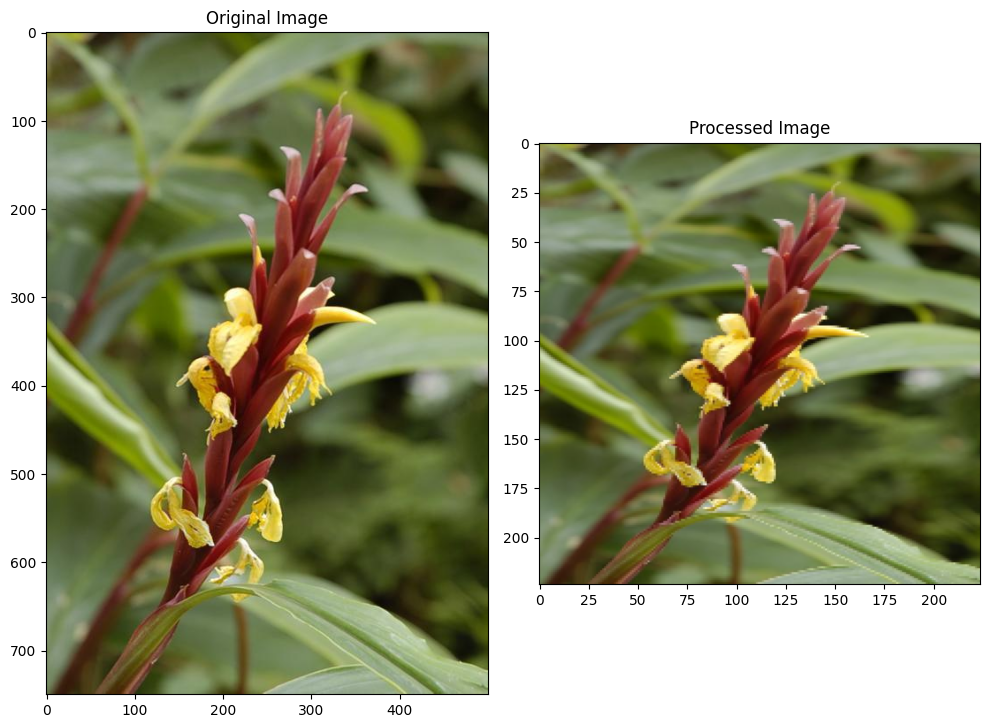

In [34]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Path to the image file.
image_path = '/kaggle/input/flowerclassificationdataset/test_images/cautleya_spicata.jpg'

# Open the image file.
original_image = Image.open(image_path)

# Convert the image to a NumPy array.
original_image_array = np.asarray(original_image)

# Process the image using the process_image function.
processed_image = process_image(image_path)

# Create a subplot with two columns to display the original and processed images.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)

# Display the original image.
ax1.imshow(original_image_array)
ax1.set_title('Original Image')

# Display the processed image.
ax2.imshow(processed_image)
ax2.set_title('Processed Image')

# Adjust the layout and show the plot.
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [35]:
# TODO: Create the predict function
def predict(image_path, model, top_k=5):
    # Process the image.
    processed_image = process_image(image_path)
    
    # Add batch dimension.
    processed_image = np.expand_dims(processed_image, axis=0)
    
    # Get model predictions.
    predictions = model.predict(processed_image)[0]
    
    # Get top K predictions.
    top_k_indices = predictions.argsort()[-top_k:][::-1]
    top_k_probs = predictions[top_k_indices]
    top_k_classes = [str(index) for index in top_k_indices]
    
    return top_k_probs, top_k_classes

# Path to the image file.
image_path = '/kaggle/input/flowerclassificationdataset/test_images/cautleya_spicata.jpg'

# Get top K probabilities and classes.
probs, classes = predict(image_path, loaded_model, top_k=5)

# Print the probabilities and classes.
print(probs)
print(classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[0.2644062  0.10901091 0.07816587 0.07672089 0.07384146]
['27', '60', '94', '40', '92']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


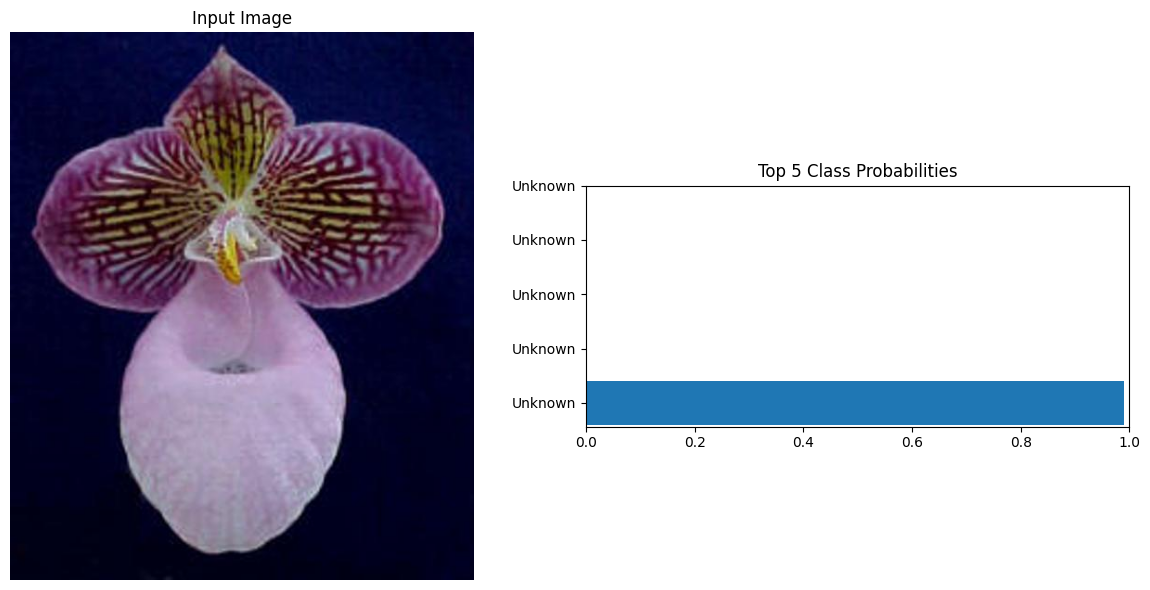

In [38]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

def process_image(image_path):
    image = Image.open(image_path)
    image = np.asarray(image)
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image.numpy()

def predict(image_path, model, top_k=5):
    # Process the image.
    processed_image = process_image(image_path)
    
    # Add batch dimension.
    processed_image = np.expand_dims(processed_image, axis=0)
    
    # Get model predictions.
    predictions = model.predict(processed_image)[0]
    
    # Get top K predictions.
    top_k_indices = predictions.argsort()[-top_k:][::-1]
    top_k_probs = predictions[top_k_indices]
    top_k_classes = [str(index) for index in top_k_indices]
    
    return top_k_probs, top_k_classes

def plot_predictions(image_path, model, class_names, top_k=5):
    # Get the top K probabilities and classes.
    probs, classes = predict(image_path, model, top_k)
    
    # Ensure that the class indices are within range of the class names list.
    class_labels = []
    for cls in classes:
        cls_index = int(cls)
        if cls_index < len(class_names):
            class_labels.append(class_names[cls_index])
        else:
            class_labels.append("Unknown")

    # Load the image.
    image = Image.open(image_path)
    
    # Plot the image and bar graph.
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
    
    ax1.imshow(image)
    ax1.set_title('Input Image')
    ax1.axis('off')
    
    ax2.barh(class_labels, probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(range(top_k))
    ax2.set_yticklabels(class_labels)
    ax2.set_title('Top 5 Class Probabilities')
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Path to the image file.
image_path = '/kaggle/input/flowerclassificationdataset/test_images/hard-leaved_pocket_orchid.jpg'

# Define class names (ensure this list covers all possible class indices predicted by the model).
class_names = ["class1", "class2", "class3", "class4", "class5", "class6", "class7", "class8", "class9", "class10"]

# Plot the predictions.
plot_predictions(image_path, loaded_model, class_names, top_k=5)
